# **Bidirectional LSTM (BiLSTM)**

---
LSTM models, known for their ability to capture sequential dependencies in data, are particularly suited for analyzing textual data like social media posts. These models excel in understanding context and detecting patterns in the sequence of words, crucial for identifying nuanced misinformation.

A Bidirectional LSTM is an extension of the traditional LSTM architecture that enhances its ability to capture patterns from sequential data by processing it in both forward and backward directions.


In [11]:
# Import important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import ParameterGrid

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/InfosysSB/Preprocessed_Dataset/FakeNewsNet_Preprocessed.csv')

In [4]:
# Show the first few rows of the dataset
df.head()

,title,news_url,source_domain,tweet_num,real
0,kandi burruss explodes rape accusation on real...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,people choice award the best red carpet look,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,sophia bush sends sweet birthday message to on...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,colombian singer maluma spark rumour of inappr...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,gossip girl year later upper east siders shock...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


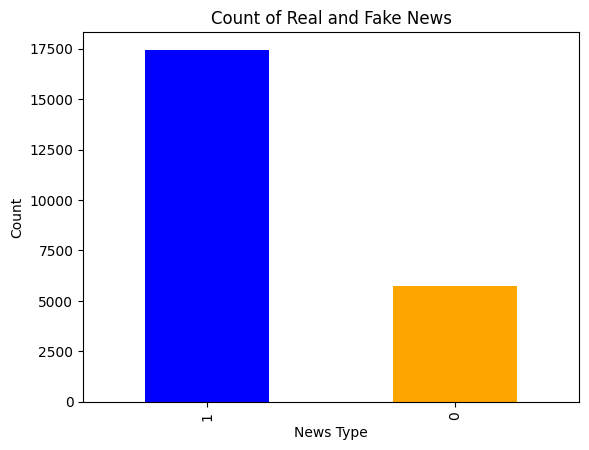

Fake News Count (0): 5755
Real News Count (1): 17441


In [5]:
# Show the count of real and fake news
df['real'].value_counts().plot(kind='bar', color=['blue', 'orange'], title='Count of Real and Fake News')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()

# Print count of real and fake news
# Get the count of 0s and 1s in the 'real' column
count_values = df['real'].value_counts()

# Print the counts with labels
fake_count = count_values[0]  # Count of fake news
real_count = count_values[1]  # Count of real news

print(f"Fake News Count (0): {fake_count}")
print(f"Real News Count (1): {real_count}")

In [6]:
# Handle any missing values in title column (if any)
df['title'].fillna("Unknown Title", inplace=True)

In [7]:
# Overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23196 non-null  object
 1   news_url       23196 non-null  object
 2   source_domain  23196 non-null  object
 3   tweet_num      23196 non-null  int64 
 4   real           23196 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 906.2+ KB


In [8]:
# Check the count of null values
print(df.isnull().sum())

title            0
news_url         0
source_domain    0
tweet_num        0
real             0
dtype: int64


In [9]:
# Combine text features into one column
X = df['title'] + ' ' + df['news_url'] + ' ' + df['source_domain']
y = df['real']

In [12]:
# Split data into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)

# Further split temp into test (20%) and validation (10%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.333, random_state=101)

In [13]:
# Tokenize text data
tokenizer_lstm = Tokenizer()
tokenizer_lstm.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer_lstm.texts_to_sequences(X_train)
X_val_seq = tokenizer_lstm.texts_to_sequences(X_val)
X_test_seq = tokenizer_lstm.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
max_seq_length = 128  # Max sequence length to pad

X_train_seq_padded = pad_sequences(X_train_seq, maxlen=max_seq_length, padding='post', truncating='post')
X_val_seq_padded = pad_sequences(X_val_seq, maxlen=max_seq_length, padding='post', truncating='post')
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=max_seq_length, padding='post', truncating='post')

In [14]:
# Define LSTM model architecture with bidirectional layer and dropout
lstm_model = Sequential()
lstm_model.add(Embedding(len(tokenizer_lstm.word_index) + 1, 128, input_length=max_seq_length))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 128)          3618048   
                                                                 
 spatial_dropout1d (Spatial  (None, 128, 128)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 3881473 (14.81 MB)
Trainable params: 3881473 (14.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [15]:
# Train the LSTM model
epochs_lstm = 5
batch_size_lstm = 32

history_lstm = lstm_model.fit(X_train_seq_padded, y_train, epochs=epochs_lstm, batch_size=batch_size_lstm,
                              validation_data=(X_val_seq_padded, y_val), verbose=1)

Epoch 1/5
508/508 [==============================] - 454s 877ms/step - loss: 0.1294 - accuracy: 0.9550 - val_loss: 0.0499 - val_accuracy: 0.9840
Epoch 2/5
508/508 [==============================] - 397s 782ms/step - loss: 0.0323 - accuracy: 0.9906 - val_loss: 0.0706 - val_accuracy: 0.9827
Epoch 3/5
508/508 [==============================] - 401s 790ms/step - loss: 0.0119 - accuracy: 0.9965 - val_loss: 0.0565 - val_accuracy: 0.9862
Epoch 4/5
508/508 [==============================] - 394s 775ms/step - loss: 0.0087 - accuracy: 0.9978 - val_loss: 0.0794 - val_accuracy: 0.9810
Epoch 5/5
508/508 [==============================] - 397s 782ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0876 - val_accuracy: 0.9840


In [16]:
# Evaluate on validation set
val_loss_lstm, val_accuracy_lstm = lstm_model.evaluate(X_val_seq_padded, y_val, verbose=0)
print(f"Validation Accuracy (LSTM Model): {val_accuracy_lstm}")

Validation Accuracy (LSTM Model): 0.9840379357337952


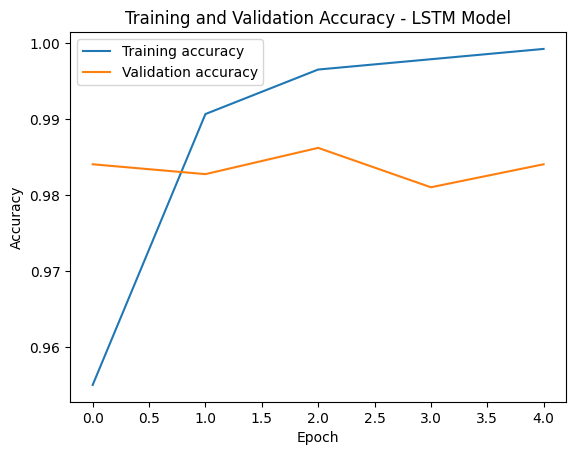

In [17]:
# Plot training history
plt.plot(history_lstm.history['accuracy'], label='Training accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - LSTM Model')
plt.legend()
plt.show()

In [18]:
# Make predictions on validation set
predictions_val_lstm_prob = lstm_model.predict(X_val_seq_padded)
predictions_val_lstm = (predictions_val_lstm_prob > 0.5).astype('int32')  # Threshold of 0.5 for binary classification

# Convert to 1D array
predictions_val_lstm = predictions_val_lstm.flatten()

# Print classification report for validation set
print("Classification Report for Validation Set (LSTM Model):")
print(classification_report(y_val, predictions_val_lstm))

73/73 [==============================] - 5s 70ms/step
Classification Report for Validation Set (LSTM Model):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       590
           1       0.99      0.99      0.99      1728

    accuracy                           0.98      2318
   macro avg       0.98      0.98      0.98      2318
weighted avg       0.98      0.98      0.98      2318



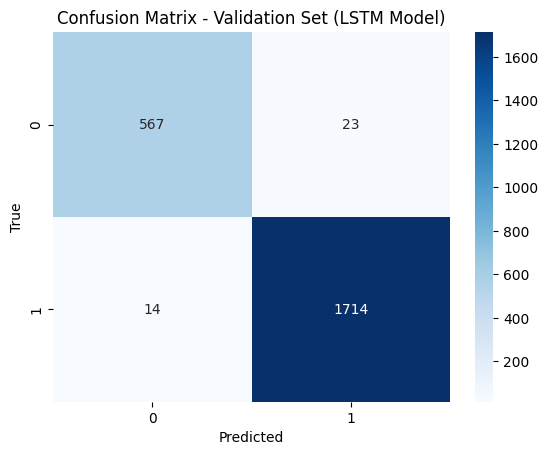

In [24]:
# Confusion matrix for validation set (LSTM Model)
val_cm_lstm = confusion_matrix(y_val, predictions_val_lstm)
sns.heatmap(val_cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Set (LSTM Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
# Evaluate on test set
test_loss_lstm, test_accuracy_lstm = lstm_model.evaluate(X_test_seq_padded, y_test, verbose=0)
print(f"Test Accuracy (LSTM Model): {test_accuracy_lstm}")

Test Accuracy (LSTM Model): 0.9879336357116699


In [25]:
# Make predictions on test set
predictions_lstm_prob = lstm_model.predict(X_test_seq_padded)
predictions_lstm = (predictions_lstm_prob > 0.5).astype('int32')  # Threshold of 0.5 for binary classification

# Convert to 1D array
predictions_lstm = predictions_lstm.flatten()

# Print classification report
print("Classification Report for Test Set (LSTM Model):")
print(classification_report(y_test, predictions_lstm))

146/146 [==============================] - 16s 110ms/step
Classification Report for Test Set (LSTM Model):
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1126
           1       0.99      0.99      0.99      3515

    accuracy                           0.99      4641
   macro avg       0.99      0.98      0.98      4641
weighted avg       0.99      0.99      0.99      4641



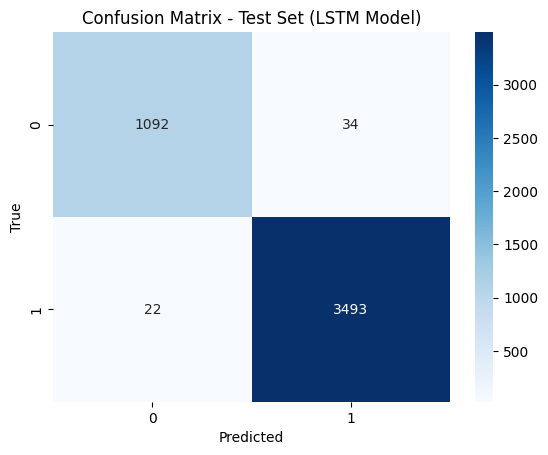

In [26]:
# Confusion matrix for test set (LSTM Model)
test_cm_lstm = confusion_matrix(y_test, predictions_lstm)
sns.heatmap(test_cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set (LSTM Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [27]:
# Define a function to predict sentiment for a given text
def predict_custom_input_lstm(text):
  """
  Predicts sentiment for a custom text input.

  Args:
      text: The custom text input string.

  Returns:
      A list containing the predicted sentiment probability (between 0 and 1)
          and the predicted class ("positive" or "negative").
  """
  # Convert the text to a sequence
  custom_seq = tokenizer_lstm.texts_to_sequences([text])

  # Pad the sequence
  custom_seq_padded = pad_sequences(custom_seq, maxlen=max_seq_length, padding='post', truncating='post')

  # Predict with the LSTM model
  prediction_prob = lstm_model.predict(custom_seq_padded)[0][0]  # Probability for the first element (custom input)
  predicted_class = "Real" if prediction_prob > 0.5 else "Fake"

  return [prediction_prob, predicted_class]

# Example usage
custom_input = "gwen stefani got dumped by blake shelton jealousy and drama exclusive"
prediction_prob, predicted_class = predict_custom_input_lstm(custom_input)

print(f"Prediction for custom input: {predicted_class}")

1/1 [==============================] - 0s 80ms/step
Prediction for custom input: Fake
